# Initialisation and imports

In [1]:
import os #Getting the Current Working Directory
import warnings #Ability to create custom warnings, like warnings.warn("deprecated", DeprecationWarning)


import urllib.request#Allows to download the cifar dataset without ssl errors.
import ssl

# Date and Time 
import time
from pytz import timezone
from datetime import datetime

import numpy as np




#Metrics
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay




# ALlows us to produce Plots
import matplotlib.pyplot as plt #Allows use of Pyplot plots

import seaborn as sns #Allows use of Seaborn plots
sns.set() #Sets default plot theme




# Neural Network Libraries 
#General
import torch
import torch.nn as nn
from torchinfo import summary

#Images
import torchvision #To load the dataset and get a numpy array


gpuAvailable = torch.cuda.is_available()
device = "cuda" if torch.cuda.is_available() else "cpu"



### Useful functions ###
def ZeroANumber(Number, maxLength, forceMaxLength = False):
    res = str(Number).zfill(maxLength)
    if forceMaxLength: res = res[:maxLength]
    return res

def SpaceAString(currentString, maxLength, SpaceTheFront = True, forceMaxLength = False, forceRemoveFont = False):
    currentLength = len(currentString)
    Result = currentString
    
    if currentLength < maxLength:
        if SpaceTheFront:
            Result = (" " * (maxLength-currentLength)) + currentString
        else:
            Result = currentString + (" " * (maxLength-currentLength))
    elif currentLength > maxLength and forceMaxLength:
        if forceRemoveFont:
            Result = currentString[(currentLength - maxLength):]
        else:
            Result = currentString[:-(currentLength - maxLength)]
    return Result




# Data

In [2]:
path_root = f"{os.getcwd()}"
path_data = f"{path_root}/Data"
path_models = f"{path_root}/Models"
print(path_data, "\n")
print(path_root)
print(path_models, "\n")

C:\Users\dsxma\Downloads/Data 

C:\Users\dsxma\Downloads
C:\Users\dsxma\Downloads/Models 



In [3]:
Seed = 1337
batch_size = 500

#Downloading the CIFAR10 dataset using PyTorch's datasets
#"transforms.ToTensor()" scales the data
train_dataset = torchvision.datasets.CIFAR10(
    root = f'{path_data}',
    train = True,
    download = True,
    transform = torchvision.transforms.ToTensor() #this transformation returns the PyTorch tensors we need.
)
test_dataset = torchvision.datasets.CIFAR10(
    root = f'{path_data}',
    train = False,
    download = True,
    transform = torchvision.transforms.ToTensor() 
)
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True
)
test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    shuffle = False
)

ClassNames = train_dataset.classes            #Isolating the Classes
tmpX, tmpY = next(iter(test_loader))

#Printing information about the data
N, C1, H1, W1 = tmpX.shape
K = len(set(tmpY.cpu().numpy())) #Number of classes

Files already downloaded and verified
Files already downloaded and verified


## Optimisation the network

In [4]:
def AccCalculation(predictedY, targets):    
    if isinstance(targets, torch.Tensor):
        targets = targets.cpu().numpy()
    
    if isinstance(predictedY, torch.Tensor):
        predictedY = predictedY.cpu().numpy()
        
    return np.mean(predictedY == targets)

In [5]:
def AUCCalculation(targets, probabilityY, predictedY, Verbose = True):
    if isinstance(targets, torch.Tensor):
        targets = targets.cpu().numpy()
    
    if isinstance(probabilityY, torch.Tensor):
        probabilityY = probabilityY.cpu().numpy()
    
    if isinstance(predictedY, torch.Tensor):
        predictedY = predictedY.cpu().numpy()
    
    try:
        CurMetric2 = roc_auc_score(targets, probabilityY, multi_class = "ovr", average = 'weighted') #Calculating Weighted AUC #Cares for performance both in Positives and Negatives (but may not fare well with heavy class imbalance)
    except Exception as exc:
        CurMetric2 = np.nan
        if Verbose:
            warnings.warn("An error has occures")
            print("AUC Warning. set(targets):", list(set(targets.reshape(-1))), "set(Outputs): ", list(set(predictedY.reshape(-1))))
            
    return CurMetric2

In [6]:
def F1ScoreCalculation(targets, predictedY):
    if isinstance(targets, torch.Tensor):
        targets = targets.cpu().numpy()
    
    if isinstance(predictedY, torch.Tensor):
        predictedY = predictedY.cpu().numpy()
    
    try:
        CurMetric3 = f1_score(targets, predictedY, average = 'weighted') #Calculating Weighted F1 #Cares about balance between Precision and Recall (Sensitivity)
    except Exception as exc:
        CurMetric3 = np.nan
        warnings.warn(f"\nAn error occurred in F1 score calculation (probably because of missing classes in the random batch of data?).\nThe error reads: {exc}")
            
    return CurMetric3

In [7]:
def PrintIterationMetrics(it, epochs, t0, train_loss, test_loss, first_metric, first_metric_Name, second_metric, second_metric_Name, third_metric, third_metric_Name, MaxTrainLossLen, MaxTestLossLen, MaxMetric1Len, MaxMetric2Len, MaxMetric3Len):
    dt = datetime.now() - t0

    strTrainLoss = f"{train_loss:.5f}"
    strTestLoss = f"{test_loss:.5f}"
    strMetric1 = f'{first_metric:.4f}'
    strMetric2 = f'{second_metric:.4f}'
    strMetric3 = f'{third_metric:.4f}'
    if it == 0:
        MaxTrainLossLen = len(strTrainLoss)
        MaxTestLossLen = len(strTestLoss)
        MaxMetric1Len = len(strMetric1)
        MaxMetric2Len = len(strMetric2)
        MaxMetric3Len = len(strMetric3)
    print(f'Epoch {ZeroANumber(it+1, len(str(epochs)))}/{epochs}, Train Loss: {SpaceAString(strTrainLoss, MaxTrainLossLen)}, Test Loss: {SpaceAString(strTestLoss, MaxTestLossLen)} | {first_metric_Name}: {SpaceAString(strMetric1, MaxMetric1Len)}, {second_metric_Name}: {SpaceAString(strMetric2, MaxMetric1Len)}, {third_metric_Name}: {SpaceAString(strMetric3, MaxMetric1Len)}, Duration: {dt}')
    return MaxTrainLossLen, MaxTestLossLen, MaxMetric1Len, MaxMetric2Len, MaxMetric3Len

In [8]:
def UpdateMetricsAndSaveModel(model, train_loss, test_loss, train_best_loss, test_best_loss, CurMetric1, Metric1, CurMetric2, Metric2, CurMetric3, Metric3):
    if (test_loss < test_best_loss): #Saving the model if it outperforms previous iteration's model
        test_best_loss = test_loss
        train_best_loss = train_loss
        torch.save(model.state_dict(), f"model_dict.pt") #Saving Model's Dictionary
        
        if np.isfinite(CurMetric1) and CurMetric1 >= Metric1:
            Metric1 = CurMetric1
            Metric2 = CurMetric2
            Metric3 = CurMetric3
            torch.save(model.state_dict(), f"acc_model_dict.pt") #Saving Model's Dictionary
    return train_best_loss, test_best_loss, Metric1, Metric2, Metric3

In [9]:
def PrintFinishingInformation(start_time, JustCalculateElapsedTime = False):
    elapsed_time = time.time() - start_time
    if not JustCalculateElapsedTime:
        FinishedOn = datetime.now(timezone('Europe/Athens')).strftime("%a, %Y-%m-%d %H:%M %Z %z")
        print("\nDone (" + FinishedOn + ") Elapsed time: " + str(round(elapsed_time, 1)) + " seconds")
    
    return elapsed_time

In [10]:
def TrainModel(model, optimiser, criterion, X_Train, Y_Train, K):
    model.train() #Putting model in training mode so that things like dropout() are activated again
    
    optimiser.zero_grad() #Initialisation of the gradient of θ
    outputs = model(X_Train) #Getting the prediction using the forward direction of the Neural Net
    
    loss = criterion(outputs, Y_Train) #Calculating the loss according to the loss function
    loss.backward() #Calculating the Gradient Δθ of the loss function with respect to the parameters
    
    optimiser.step() #Calculates and updates the parameters θ using gradient descent, as θ = θ - η*Δθ
    
    return optimiser, outputs, loss

In [11]:
def EvaluateModel(model, criterion, Inputs, targets):
    model.eval() #Putting model in evaluation mode so that things like dropout() are deactivated
    with torch.no_grad(): #Making sure that we don't update the gradient outside the training part
        probabiltyY = model(Inputs) #Getting the prediction using the forward direction of the Neural Net
        
        loss_scalar = criterion(probabiltyY, targets).item() #Calculating the loss according to the loss function

        probabiltyY = nn.Softmax(dim = 1)(probabiltyY) #dim: every slice along dim will sum to 1
        _, predictedY = torch.max(probabiltyY, 1) #Prediction. torch.max returns both max (value) and argmax (index)

        CurMetric1, CurMetric2, CurMetric3 = GetCategoricalMetrics(probabiltyY, predictedY, targets)
        
        return probabiltyY, predictedY, loss_scalar, CurMetric1, CurMetric2, CurMetric3

In [12]:
def EvalForwardPass(model, inputs, criterion = None, targets = None): #This is used at the very end on "Evaluation" Section. Unifies the forward pass, but doesn't calculate loss/metrics like EvaluateModel() does as we need greater granularity.
    if targets is not None and criterion is None:
        warnings.warn(f"\nTargets are present but loss cannot be calculated because criterion is None.")  
        
    model.eval() #Putting model in evaluation mode so that things like dropout() are deactivated
    with torch.no_grad(): #Making sure that we don't update the gradient outside the training part
        probabilityY = model(inputs) #Getting the prediction using the forward direction of the Neural Net
        
        if targets is not None:
            loss_scalar = criterion(probabilityY, targets).item() #Calculating the loss according to the loss function

        probabilityY = nn.Softmax(dim = 1)(probabilityY) #dim: every slice along dim will sum to 1
        _, predictedY = torch.max(probabilityY, 1) #Prediction. torch.max returns both max (value) and argmax (index)
        
    if targets is not None:
        return probabilityY, predictedY, loss_scalar
    else:
        return probabilityY, predictedY

In [13]:
def FixFormatAndDTypes(device, Inputs, targets):
    if isinstance(Inputs, np.ndarray):
        Inputs = torch.from_numpy(Inputs)
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    
    Inputs = Inputs.to(device)
    targets = targets.to(device)
    targets = targets.long()
    
    return Inputs, targets

## Evaluation Functions

In [14]:
def GetCategoricalMetrics(probabilityY, predictedY, targets):
    test_Acc = AccCalculation(predictedY, targets)
    test_AUC = AUCCalculation(targets, probabilityY, predictedY)
    test_F1 = F1ScoreCalculation(targets, predictedY)
    
    return test_Acc, test_AUC, test_F1

In [15]:
def PlotCategoricalMetrics(probabilityY, targets, ClassNames, normalise):
    cm = confusion_matrix(targets, probabilityY)
    plot_confusion_matrix(cm, ClassNames, normalise = normalise)

In [16]:
def EvalPredict(model, test_batch_size, device, loaderOrX, testY):
    Preds_prob = []
    Preds = []
    Targets = []
    
    for inputs, targets in loaderOrX:
        inputs, targets = FixFormatAndDTypes(device, inputs, targets)
        outputs_prob, outputs = EvalForwardPass(model, inputs)

        Preds_prob.append(outputs_prob)
        Preds.append(outputs)
        Targets.append(targets)
        
    Preds_prob = torch.cat(Preds_prob).cpu().numpy()
    Preds = torch.cat(Preds).cpu().numpy()
    Targets = torch.cat(Targets).cpu().numpy()
    
    del inputs
    del outputs_prob
    del outputs
    del targets
    if IS_GPU_AVAILABLE:
        torch.cuda.empty_cache()
    
    return Preds_prob, Preds, Targets

## Architecture

In [17]:
#Static
class Net(nn.Module):
    def __init__(self, H1, W1, K, activation, num_units, usebias, dropout, conv_filter_size, conv_stride, conv_padding, conv_dilation, conv_pool_size, conv_pool_dilation, conv_pool_stride, conv_pool_padding, ReluAlpha, EluAlpha):
        super(Net, self).__init__()
        self.conv_pool_size = conv_pool_size
        self.usebias = usebias
        self.dropout = dropout
        self.K = K
        self.conv_pool_dilation = conv_pool_dilation
        self.conv_pool_stride = conv_pool_stride
        self.H1 = H1
        self.ReluAlpha = ReluAlpha
        self.EluAlpha = EluAlpha
        self.W1 = W1
        self.conv_dilation = conv_dilation
        self.activation = activation
        self.num_units = num_units
        self.conv_filter_size = conv_filter_size
        self.conv_stride = conv_stride
        self.conv_padding = conv_padding
        
        self.conv_pool_padding = conv_pool_padding
       
        
        self.CNN_Layer = nn.ModuleList([
            nn.Conv2d(in_channels = self.num_units[0], out_channels = self.num_units[1], kernel_size = self.conv_filter_size, stride = self.conv_stride, padding = self.conv_padding, dilation = self.conv_dilation, bias = self.usebias[0]),
            self.GetActivationLayer(0),
            nn.Dropout(p = self.dropout[0], inplace = False),
            nn.MaxPool2d(kernel_size = self.conv_pool_size, dilation = self.conv_pool_dilation, stride = self.conv_pool_stride, padding = self.conv_pool_padding),
            nn.Conv2d(in_channels = self.num_units[1], out_channels = self.num_units[1], kernel_size = self.conv_filter_size, stride = self.conv_stride, padding = self.conv_padding, dilation = self.conv_dilation, bias = self.usebias[0]),
            self.GetActivationLayer(0),
            nn.Dropout(p = self.dropout[0], inplace = False),
            nn.MaxPool2d(kernel_size = self.conv_pool_size, dilation = self.conv_pool_dilation, stride = self.conv_pool_stride, padding = self.conv_pool_padding),
            nn.Conv2d(in_channels = self.num_units[1], out_channels = self.num_units[1], kernel_size = self.conv_filter_size, stride = self.conv_stride, padding = self.conv_padding, dilation = self.conv_dilation, bias = self.usebias[0]),
            self.GetActivationLayer(0),
            nn.Dropout(p = self.dropout[0], inplace = False),
            nn.MaxPool2d(kernel_size = self.conv_pool_size, dilation = self.conv_pool_dilation, stride = self.conv_pool_stride, padding = self.conv_pool_padding)
        ])
        
        self.MLP_Layers = nn.ModuleList([
            nn.Linear(in_features = int((((self.H1/self.conv_pool_size)/2)/2) * (((self.W1/self.conv_pool_size)/2)/2) * num_units[1]), out_features = self.num_units[2], bias = self.usebias[1]),
            self.GetActivationLayer(1),
            nn.Dropout(p = self.dropout[1], inplace = False),
            nn.Linear(in_features = self.num_units[2], out_features = self.num_units[3], bias = self.usebias[2]),
            self.GetActivationLayer(2),
            nn.Dropout(p = self.dropout[2], inplace = False),
            nn.Linear(in_features = self.num_units[3], out_features = self.num_units[4], bias = self.usebias[3]),
            self.GetActivationLayer(3),
            nn.Dropout(p = self.dropout[3], inplace = False),
        ])
        
        self.Output_Layer = nn.ModuleList([
            nn.Linear(in_features = self.num_units[-1], out_features = self.K, bias = self.usebias[-1])
        ])
        
    def GetActivationLayer(self, layer):
        Result = None
        if (self.activation[layer] == "relu"):
            if (self.ReluAlpha == 0):
                Result = nn.ReLU()
            else:
                Result = self.layers.append(nn.LeakyReLU(negative_slope = self.ReluAlpha)) #alpha: Controls the angle of the negative slope
        elif (self.activation[layer] == "relu6"):
            Result = nn.ReLU6()
        elif (self.activation[layer] == "elu"): # centred around 0, Similar to ReLu but values can be  negative,
            Result = nn.ELU(alpha = self.EluAlpha) 
        elif (self.activation[layer] == "tanh"): #Does have a disappering gradient
            Result = nn.Tanh()
        elif (self.activation[layer] == "sigmoid"): #Suffers from Vanishing Gradient
            Result = nn.Sigmoid() # Maximum derivative is a Quarter, Result isn't centred around 0.
        return Result
        
    def forward(self, x):
        print(f"X: {x.shape}") if Debug else None
        
        #Convolutional Layers
        out = self.CNN_Layer[0](x)
        print(f"CNN Output: {out.shape}") if Debug else None
        out = self.CNN_Layer[1](out)
        out = self.CNN_Layer[2](out)
        out = self.CNN_Layer[3](out)
        out = self.CNN_Layer[4](out)
        out = self.CNN_Layer[5](out)
        out = self.CNN_Layer[6](out)
        out = self.CNN_Layer[7](out)
        out = self.CNN_Layer[8](out)
        out = self.CNN_Layer[9](out)
        out = self.CNN_Layer[10](out)
        out = self.CNN_Layer[11](out)
        print(f"Maxpool Output: {out.shape}") if Debug else None
        

        out = out.view(out.shape[0], -1)
        print(f"Flatten's Output: {out.shape}") if Debug else None
        
        #MLP 
        out = self.MLP_Layers[0](out)
        print(f"Dense 1 output: {out.shape}") if Debug else None
        out = self.MLP_Layers[1](out)
        out = self.MLP_Layers[2](out)
        out = self.MLP_Layers[3](out)
        print(f"Dense 2 output: {out.shape}") if Debug else None
        out = self.MLP_Layers[4](out)
        out = self.MLP_Layers[5](out)
        out = self.MLP_Layers[6](out)
        print(f"Dense 3 output: {out.shape}") if Debug else None
        out = self.MLP_Layers[7](out)
        out = self.MLP_Layers[8](out)
        
        #Output layer
        out = self.Output_Layer[0](out)
        print(f"Prediction: {out.shape}") if Debug else None
        
        return out
print("Done")

Done


# Parametising the Network

In [18]:
ReluAlpha = 0 #0.01 for leakyRelu
EluAlpha = 0.8

conv_pool_size = 2 
conv_pool_dilation = 1 
conv_pool_stride = conv_pool_size 
conv_pool_padding = 0 

conv_filter_size = 3
conv_stride = 1
conv_dilation = 1
conv_padding = 1


NUM = 1 
num_units = [C1, 50, 200, 100, 50]
num_units = [num_units[0], *[n_unit * NUM for n_unit in num_units[1:]]]
activation = ["relu"] + ["relu"] * (len(num_units)-2)

dropout    = [0.0] + [0.3] * (len(num_units)-2) 
usebias = [True] * (len(num_units)-1) + [True]
l2_lamda = 0.1
mu = 0.99


## Optimisation

### Structure

In [19]:
Debug = False
model = Net(H1, W1, K, activation, num_units, usebias, dropout, conv_filter_size, conv_stride, conv_padding, conv_dilation, conv_pool_size, conv_pool_dilation, conv_pool_stride, conv_pool_padding, ReluAlpha, EluAlpha).to(device)

train_losses = np.array([])
test_losses = np.array([])
train_best_loss = np.Inf
test_best_loss = np.Inf
Metric1 = 0 #Initialising as the worst possible value
Metric2 = np.nan
Metric3 = np.nan

In [20]:
criterion = nn.CrossEntropyLoss() #Using Categorical Cross Entropy loss function
print("Multiclass Classification")

learning_rate = 1e-3

# optimiser = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = mu, nesterov = False, weight_decay = l2_lamda) #LR=0.01
#Adam is fast, but tends to overfit
# optimiser = torch.optim.Adam(model.parameters(), lr = learning_rate, betas = (mu, 0.999), weight_decay = l2_lamda, amsgrad = False) #LR=0.001 (0.9, 0.999)
optimiser = torch.optim.AdamW(model.parameters(), lr = learning_rate, betas = (mu, 0.999), weight_decay = l2_lamda, amsgrad = False) #LR=0.001 (0.9, 0.999)

Multiclass Classification


### Stochastic Gradient Descent (Dataset)

#### Function

In [21]:
def batch_gd(model, criterion, optimiser, scheduler, train_loader, test_loader, Runs, printRuns, Verbose):
    global train_best_loss 
    global Metric2 
    global Metric3
    global test_best_loss 
    global Metric1 
     
    MaxTrainLossLen, MaxTestLossLen, MaxMetric1Len, MaxMetric2Len, MaxMetric3Len = None, None, None, None, None #For output text formatting
    
    start_time = time.time() 
    model = model.to(device) 
    

    #Initialise Loss
    train_losses = np.zeros(Runs) 
    test_losses = np.zeros(Runs)  
    for it in range(Runs):
        t0 = datetime.now() 
        train_loss = [] 
        train_weights = []
        
        #Training the Network
        for inputs, targets in train_loader:
            inputs, targets = FixFormatAndDTypes(device, inputs, targets) #Making sure we have Tensors of the correct Format and Data Type
            optimiser, outputs, loss = TrainModel(model, optimiser, criterion, inputs, targets, K) #Training the model on Train set
            train_loss.append(loss.item())
            train_weights.append(targets.shape[0])
        train_loss = np.average(train_loss, weights = train_weights) #Weighted average based on number of samples #Alternatively we could add all Iteration Losses instead of 1 Epoch loss, but the array length will be higher than Validation's
        
        #Evaluating the network
        test_loss = []
        test_metric1 = []
        test_metric2 = []
        test_metric3 = []
        test_weights = []
        for inputs, targets in test_loader:
            inputs, targets = FixFormatAndDTypes(device, inputs, targets) #Making sure we have Tensors of the correct Format and Data Type
            _, _, cur_test_loss, cur_test_metric1, cur_test_metric2, cur_test_metric3 = EvaluateModel(model, criterion, inputs, targets) #Evaluating the model on Evaluation set
            test_loss.append(cur_test_loss)
            test_metric1.append(cur_test_metric1)
            test_metric2.append(cur_test_metric2)
            test_metric3.append(cur_test_metric3)
            test_weights.append(targets.shape[0])


        #Weights are determined by number of samples
        test_loss = np.average(test_loss, weights = test_weights) 
        CurMetric1 = np.average(test_metric1, weights = test_weights) 
        CurMetric2 = np.average(test_metric2, weights = test_weights) 
        CurMetric3 = np.average(test_metric3, weights = test_weights)

        if scheduler is not None:
            scheduler.step()
        
        train_losses[it] = train_loss
        test_losses[it] = test_loss


        #Printing information about the Loss and metric
        if (it + 1) % printRuns == 0 or it == 0 or it == Runs - 1: 
            MaxTrainLossLen, MaxTestLossLen, MaxMetric1Len, MaxMetric2Len, MaxMetric3Len = PrintIterationMetrics( #Prints Iteration Metrics
                it, Runs, t0, train_loss, test_loss,
                CurMetric1, "Acc",
                CurMetric2, "AUC",
                CurMetric3, "F1",
                MaxTrainLossLen, MaxTestLossLen,
                MaxMetric1Len, MaxMetric2Len, MaxMetric3Len
            )
        
        train_best_loss, test_best_loss, Metric1, Metric2, Metric3 = UpdateMetricsAndSaveModel(model, train_loss, test_loss, train_best_loss, test_best_loss, CurMetric1, Metric1, CurMetric2, Metric2, CurMetric3, Metric3) #Updating Metrics and Saving the model if it outperforms previous iteration's model
    
    elapsed_time = PrintFinishingInformation(start_time, JustCalculateElapsedTime = False) #Prints finishing information
    return train_losses, test_losses, train_best_loss, test_best_loss, Metric1, Metric2, Metric3, elapsed_time

#### Procedure

In [22]:
GDType = "stochastic"
Debug = False
Runs = int(100)
PrintInfoEverynEpochs = 20
scheduler = None #torch.optim.lr_scheduler.StepLR(optimiser, step_size = Runs // 10 if Runs > 10 else 3, gamma = 0.8)

new_train_losses, new_test_losses, train_best_loss, test_best_loss, Metric1, Metric2, Metric3, elapsed_time = batch_gd(model, criterion, optimiser, scheduler, train_loader, test_loader, epochs = Runs, PrintInfoEverynEpochs = PrintInfoEverynEpochs, Verbose = False)
train_losses = np.append(train_losses, new_train_losses)
test_losses = np.append(test_losses, new_test_losses)
train_loss = train_losses[-1]
test_loss = test_losses[-1]
print("\ntrain_best_loss:", train_best_loss, "test_best_loss:", test_best_loss, "Acc:", Metric1, "AUC:", Metric2, "F1:", Metric3)
torch.cuda.empty_cache()

Epoch 001/100, Train Loss: 2.13121, Test Loss: 1.92965 | Acc: 0.2787, AUC: 0.7644, F1: 0.2156, Duration: 0:01:33.011483
Epoch 002/100, Train Loss: 1.86470, Test Loss: 1.69665 | Acc: 0.3811, AUC: 0.8250, F1: 0.3482, Duration: 0:01:32.367495
Epoch 003/100, Train Loss: 1.74391, Test Loss: 1.60651 | Acc: 0.4014, AUC: 0.8473, F1: 0.3837, Duration: 0:01:36.101063
Epoch 004/100, Train Loss: 1.63132, Test Loss: 1.51197 | Acc: 0.4497, AUC: 0.8639, F1: 0.4327, Duration: 0:01:33.840324
Epoch 005/100, Train Loss: 1.55735, Test Loss: 1.44546 | Acc: 0.4678, AUC: 0.8767, F1: 0.4553, Duration: 0:01:31.563794
Epoch 006/100, Train Loss: 1.49116, Test Loss: 1.37088 | Acc: 0.4888, AUC: 0.8883, F1: 0.4739, Duration: 0:01:31.640961
Epoch 007/100, Train Loss: 1.43850, Test Loss: 1.33364 | Acc: 0.5141, AUC: 0.8954, F1: 0.5056, Duration: 0:01:34.997896
Epoch 008/100, Train Loss: 1.39300, Test Loss: 1.33017 | Acc: 0.5096, AUC: 0.8992, F1: 0.5084, Duration: 0:01:37.409754
Epoch 009/100, Train Loss: 1.34787, Test

Epoch 070/100, Train Loss: 0.44598, Test Loss: 0.91542 | Acc: 0.7310, AUC: 0.9595, F1: 0.7300, Duration: 0:01:47.312806
Epoch 071/100, Train Loss: 0.46350, Test Loss: 0.92611 | Acc: 0.7295, AUC: 0.9583, F1: 0.7287, Duration: 0:01:58.631816
Epoch 072/100, Train Loss: 0.46128, Test Loss: 0.88915 | Acc: 0.7383, AUC: 0.9592, F1: 0.7373, Duration: 0:01:55.774959
Epoch 073/100, Train Loss: 0.44452, Test Loss: 0.90674 | Acc: 0.7319, AUC: 0.9596, F1: 0.7339, Duration: 0:01:46.145361
Epoch 074/100, Train Loss: 0.44924, Test Loss: 0.92875 | Acc: 0.7324, AUC: 0.9586, F1: 0.7300, Duration: 0:01:57.015865
Epoch 075/100, Train Loss: 0.44296, Test Loss: 0.89364 | Acc: 0.7351, AUC: 0.9600, F1: 0.7344, Duration: 0:01:45.571363
Epoch 076/100, Train Loss: 0.43463, Test Loss: 0.95825 | Acc: 0.7258, AUC: 0.9576, F1: 0.7254, Duration: 0:01:57.368361
Epoch 077/100, Train Loss: 0.43699, Test Loss: 0.91123 | Acc: 0.7281, AUC: 0.9582, F1: 0.7285, Duration: 0:01:45.831871
Epoch 078/100, Train Loss: 0.42101, Test

# Evaluation

## Multiclass Classification

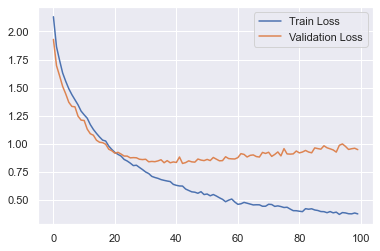

In [24]:
plt.plot(train_losses, label = f"Train Loss")
plt.plot(test_losses, label = f"Validation Loss")
plt.legend()
plt.show()

Overall Acc: 73.26%. AUC: 0.96, F1: 0.73


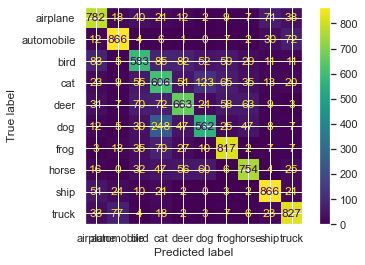

In [25]:
test_batch_size = batch_size #We *can* have a larger batch size on evaluation as we don't need any extra RAM for gradients calculation

model.eval() #Putting model in evaluation mode so that things like dropout() are deactivated
with torch.no_grad(): #Making sure that we don't update the gradient outside the training part
    model = model.to(device) #Moving the model to the appropriate device (CPU/CUDA/etc.)
    
    #Using the Forward direction of the model to get the Predictions (also returning the corresponding targ
    Preds_prob, Preds, targets = EvalPredict(model, test_batch_size, device, test_loader if "test_loader" in locals() or "test_loader" in globals() else X_Test, Y_Test if "Y_Test" in locals() or "Y_Test" in globals() else None)
    
    #Calculating evaluation metrics
    test_Acc, test_AUC, test_F1 = GetCategoricalMetrics(Preds_prob, Preds, targets)
    print(f'Overall Acc: {test_Acc * 100:.2f}%. AUC: {test_AUC:.2f}, F1: {test_F1:.2f}')
    
    #Plotting the confusion matrix
    ConfusionMatrixDisplay(confusion_matrix(targets, Preds), display_labels = ClassNames).plot()
    plt.show()

# Different Parameters 2

In [26]:
conv_filter_size = 3
conv_stride = 1
conv_dilation = 1
conv_padding = 1

conv_pool_size = 2 #Def 2
conv_pool_dilation = 1 
conv_pool_stride = conv_pool_size 
conv_pool_padding = 0  

ReluAlpha = 0 #0.01 def leakyRelu
EluAlpha = 0.8

NUM = 1 #Multiply num_units by
num_units = [C1, 50, 200, 100, 50]
num_units = [num_units[0], *[n_unit * NUM for n_unit in num_units[1:]]]

activation = ["relu"] + ["relu"] * (len(num_units)-2) #None, "relu6" "relu", "elu", "tanh", "sigmoid"

dropout    = [0.3] + [0.3] * (len(num_units)-2) #Might be a bad idea on CNN as we're trying to find patterns

usebias = [True] * (len(num_units)-1) + [True]

l2_lamda = 0.1
mu = 0.99 




nPadding: 1
num_units [3, 50, 200, 100, 50]


In [27]:
Debug = False
model = Net(H1, W1, K, activation, num_units, usebias, dropout, conv_filter_size, conv_stride, conv_padding, conv_dilation, conv_pool_size, conv_pool_dilation, conv_pool_stride, conv_pool_padding, ReluAlpha, EluAlpha).to(device)
model = nn.DataParallel(model)

train_losses = np.array([])
test_losses = np.array([])
train_best_loss = np.Inf
test_best_loss = np.Inf
Metric1 = 0 #Initialising as the worst possible value
Metric2 = np.nan
Metric3 = np.nan

In [28]:
criterion = nn.CrossEntropyLoss() #Using Categorical Cross Entropy loss function
learning_rate = 1e-3
optimiser = torch.optim.AdamW(model.parameters(), lr = learning_rate, betas = (mu, 0.999), weight_decay = l2_lamda, amsgrad = False)

In [29]:
GDType = "stochastic"
Debug = False
Epochs = int(100)
PrintInfoEverynEpochs = 1
scheduler = None #torch.optim.lr_scheduler.StepLR(optimiser, step_size = Epochs // 10 if Epochs > 10 else 3, gamma = 0.8)

new_train_losses, new_test_losses, train_best_loss, test_best_loss, Metric1, Metric2, Metric3, elapsed_time = batch_gd(model, criterion, optimiser, scheduler, train_loader, test_loader, epochs = Epochs, PrintInfoEverynEpochs = PrintInfoEverynEpochs, Verbose = False)
train_losses = np.append(train_losses, new_train_losses)
test_losses = np.append(test_losses, new_test_losses)
train_loss = train_losses[-1]
test_loss = test_losses[-1]
print("\ntrain_best_loss:", train_best_loss, "test_best_loss:", test_best_loss, "Acc:", Metric1, "AUC:", Metric2, "F1:", Metric3)
torch.cuda.empty_cache()

Epoch 001/100, Train Loss: 2.12106, Test Loss: 1.99731 | Acc: 0.3118, AUC: 0.7766, F1: 0.2698, Duration: 0:02:49.949923
Epoch 002/100, Train Loss: 1.84158, Test Loss: 1.84069 | Acc: 0.3613, AUC: 0.8108, F1: 0.3380, Duration: 0:03:01.770383
Epoch 003/100, Train Loss: 1.73089, Test Loss: 1.76703 | Acc: 0.4051, AUC: 0.8332, F1: 0.3853, Duration: 0:02:52.851432
Epoch 004/100, Train Loss: 1.63328, Test Loss: 1.67558 | Acc: 0.4378, AUC: 0.8569, F1: 0.4250, Duration: 0:02:48.415673
Epoch 005/100, Train Loss: 1.55620, Test Loss: 1.61981 | Acc: 0.4720, AUC: 0.8710, F1: 0.4660, Duration: 0:03:09.005359
Epoch 006/100, Train Loss: 1.48694, Test Loss: 1.54891 | Acc: 0.5032, AUC: 0.8837, F1: 0.5011, Duration: 0:03:08.802177
Epoch 007/100, Train Loss: 1.42806, Test Loss: 1.48642 | Acc: 0.5131, AUC: 0.8923, F1: 0.5121, Duration: 0:02:49.978296
Epoch 008/100, Train Loss: 1.36376, Test Loss: 1.42233 | Acc: 0.5305, AUC: 0.9010, F1: 0.5236, Duration: 0:02:51.107526
Epoch 009/100, Train Loss: 1.33208, Test

Epoch 070/100, Train Loss: 0.64578, Test Loss: 0.78072 | Acc: 0.7473, AUC: 0.9668, F1: 0.7522, Duration: 0:03:03.846663
Epoch 071/100, Train Loss: 0.64020, Test Loss: 0.76385 | Acc: 0.7447, AUC: 0.9667, F1: 0.7458, Duration: 0:02:45.199957
Epoch 072/100, Train Loss: 0.63688, Test Loss: 0.74116 | Acc: 0.7533, AUC: 0.9687, F1: 0.7558, Duration: 0:02:48.527367
Epoch 073/100, Train Loss: 0.62772, Test Loss: 0.74982 | Acc: 0.7558, AUC: 0.9676, F1: 0.7583, Duration: 0:03:09.971389
Epoch 074/100, Train Loss: 0.62459, Test Loss: 0.78341 | Acc: 0.7365, AUC: 0.9660, F1: 0.7357, Duration: 0:03:47.786233
Epoch 075/100, Train Loss: 0.63965, Test Loss: 0.86033 | Acc: 0.7138, AUC: 0.9613, F1: 0.7164, Duration: 0:03:42.705200
Epoch 076/100, Train Loss: 0.63261, Test Loss: 0.75790 | Acc: 0.7485, AUC: 0.9674, F1: 0.7490, Duration: 0:02:51.197794
Epoch 077/100, Train Loss: 0.63115, Test Loss: 0.71770 | Acc: 0.7606, AUC: 0.9705, F1: 0.7641, Duration: 0:02:59.678966
Epoch 078/100, Train Loss: 0.64679, Test

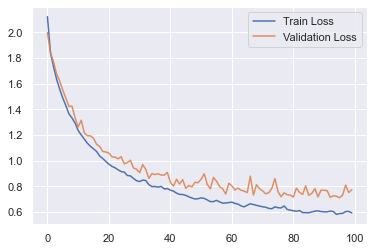

In [32]:
plt.plot(train_losses, label = f"Train Loss")
plt.plot(test_losses, label = f"Validation Loss", alpha = 0.90)
plt.legend()
plt.show()

Overall Acc: 74.69%. AUC: 0.97, F1: 0.75


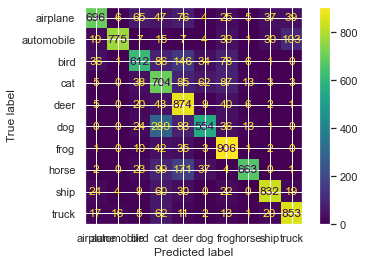

In [33]:
test_batch_size = batch_size #We *can* have a larger batch size on evaluation as we don't need any extra RAM for gradients calculation

model.eval() #Putting model in evaluation mode so that things like dropout() are deactivated
with torch.no_grad(): #Making sure that we don't update the gradient outside the training part
    model = model.to(device) #Moving the model to the appropriate device (CPU/CUDA/etc.)
    
    #Using the Forward direction of the model to get the Predictions (also returning the corresponding targets in case there's suffling and X_Test isn't indexed the same)
    Preds_prob, Preds, targets = EvalPredict(model, test_batch_size, device, test_loader if "test_loader" in locals() or "test_loader" in globals() else X_Test, Y_Test if "Y_Test" in locals() or "Y_Test" in globals() else None)
    
    #Calculating evaluation metrics
    test_Acc, test_AUC, test_F1 = GetCategoricalMetrics(Preds_prob, Preds, targets)
    print(f'Overall Acc: {test_Acc * 100:.2f}%. AUC: {test_AUC:.2f}, F1: {test_F1:.2f}')
    
    #Plotting the confusion matrix
    ConfusionMatrixDisplay(confusion_matrix(targets, Preds), display_labels = ClassNames).plot()
    plt.show()